In [154]:
import numpy as np
from sklearn import preprocessing

# 1. Manual calculation

In [171]:
# This is original y values

y = np.array([26,17,13,38,26,20,15,50,37,27,22,76,53,37,27,108,83,57,41,157,124,87,63], dtype = float)
y = y.reshape(-1,1)
y

array([[ 26.],
       [ 17.],
       [ 13.],
       [ 38.],
       [ 26.],
       [ 20.],
       [ 15.],
       [ 50.],
       [ 37.],
       [ 27.],
       [ 22.],
       [ 76.],
       [ 53.],
       [ 37.],
       [ 27.],
       [108.],
       [ 83.],
       [ 57.],
       [ 41.],
       [157.],
       [124.],
       [ 87.],
       [ 63.]])

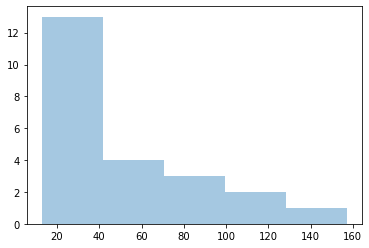

In [172]:
# As we can see y is not normally distributed

import seaborn as sns

sns.distplot(y, kde = False)

In [173]:
# this are the x1 and x2 features
X = np.array([[0,0],
              [10,0],
              [20,0],
              [0,12],
              [10,12],
              [20,12],
              [30,12],
              [0,24],
              [10,24],
              [20,24],
              [30,24],
              [0,36],
              [10,36],
              [20,36],
              [30,36],
              [0,48],
              [10,48],
              [20,48],
              [30,48],
              [0,60],
              [10,60],
              [20,60],
              [30,60]])


In [174]:
# let's find geometric mean of y

from scipy.stats import gmean
y_gmean = gmean(y)
y_gmean

array([41.54611088])

In [175]:
# lmbda is the power of y (y^lmbda)
lmbda = np.hstack((np.linspace(-1,1,20), np.array([0])))
lmbda 

array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ,
        0.        ])

#### this equation is applied when lambda != 0.
#### $y_transformed = (y**(lmbda)-1) / (lmbda*y_gmean**(lmbda-1))$

#### this equation is applied when lambda = 0.
#### $ y_transformed = y_gmean*np.log(y)$


In [176]:
# create empty array to hold each set of transformed y values

y_all_trans = np.zeros(shape = (y.shape[0],lmbda.shape[0]))
y_all_trans.shape

(23, 21)

In [177]:
# Here, I will manually transform y using box-cox method for each lambda value 
# and save each set of new y values in y_all_trans array

for index,value in enumerate(lmbda):
    if value==0:
        y_trans = y_gmean*np.log(y)
    else:
        y_trans = (y**(value)-1) / (value*y_gmean**(value-1))
    for j in np.arange(y_all_trans.shape[0]):
        y_all_trans[j,index] = y_trans[j]
y_all_trans[:,-1]

array([135.36124003, 117.70899574, 106.56367041, 151.12755793,
       135.36124003, 124.46102521, 112.50895393, 162.52934155,
       150.01959598, 136.92920388, 128.4207925 , 179.92512755,
       164.95018807, 150.01959598, 136.92920388, 194.52434312,
       183.58564185, 167.97305627, 154.28447685, 210.06734887,
       200.2639524 , 185.54111388, 172.13113474])

In [178]:
# Then, ols will be fitted to each set of transformed y values
from sklearn.linear_model import LinearRegression

# empty array to hold residual sum of square values
sse_all = np.zeros(21)

ols = LinearRegression()
for i in np.arange(y_all_trans.shape[1]):
    ols.fit(X,y_all_trans[:,i])
    sse = np.sum((ols.predict(X)-y_all_trans[:,i])**2)
    sse_all[i]=sse

# the best value of lmbda is when sse is minimized
sse_min = np.min(sse_all)
sse_min

83.16089542379224

Text(0, 0.5, 'SSE(lambda,y)')

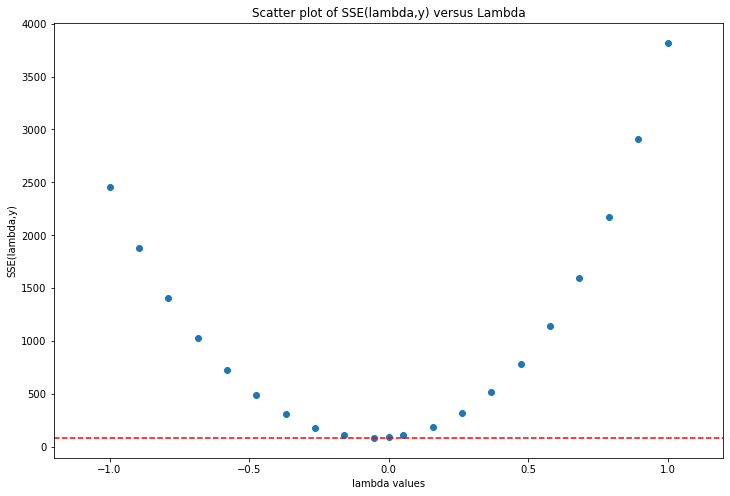

In [179]:
# Here, we visualize the relationship between residual sum of squares and lambda values 

import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.xlim(-1.2,1.2)
plt.scatter(lmbda,sse_all)
plt.hlines(np.min(sse_all), xmin = -1.2, xmax = 1.2,linestyles='dashed', color='red' )

plt.title('Scatter plot of SSE(lambda,y) versus Lambda')
plt.xlabel('lambda values')
plt.ylabel('SSE(lambda,y)')

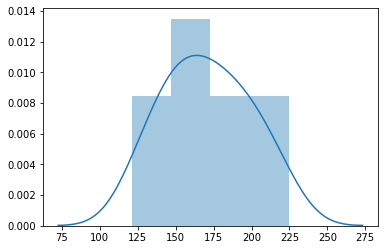

In [180]:
# After transformation, we can see that the distribution of y is close to the Gaussian.
best_lmbda_index = np.where(sse_all == np.min(sse_all))

sns.distplot(y_all_trans[:,best_lmbda_index])

In [181]:
best_lmbda = lmbda[best_lmbda_index]
print(best_lmbda)

[-0.05263158]


# 2. Using Sklearn 

In [182]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'box-cox', standardize = False)
pt.fit(y)
pt.lambdas_

array([-0.13428651])

In [183]:
y_tr = pt.transform(y)
y_tr

array([[2.63886048],
       [2.35656352],
       [2.16985001],
       [2.87773464],
       [2.63886048],
       [2.46644913],
       [2.2702858 ],
       [3.04305289],
       [2.86134276],
       [2.66316538],
       [2.52978537],
       [3.28382855],
       [3.07737628],
       [2.86134276],
       [2.66316538],
       [3.47570638],
       [3.33279258],
       [3.11985994],
       [2.92411943],
       [3.67027813],
       [3.54869722],
       [3.35871307],
       [3.17762388]])

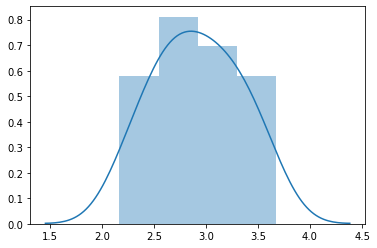

In [184]:
sns.distplot(y_tr)

In [185]:
ols_ = LinearRegression()
ols_.fit(X,y_tr)
y_pr = ols_.predict(X)
y_pr

sse = np.sum((y_pr-y_tr)**2)
sse

0.020907258154053122